In [79]:
%pylab inline
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats
import scipy

#MY SETUP FOR MATPLOTLIB
def setup_mpl():
    mpl.rc('font', size=7)
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['xtick.labelsize'] = 'small'
    mpl.rcParams['ytick.labelsize'] = 'small'
    mpl.rcParams['font.family']='Helvetica 55 Roman'
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.major.width'] = 2/3.
    mpl.rcParams['ytick.major.width'] = 2/3.
    mpl.rcParams['xtick.minor.width'] = 2/3.
    mpl.rcParams['ytick.minor.width'] = 2/3.
    mpl.rcParams['xtick.major.size'] = 3
    mpl.rcParams['ytick.major.size'] = 3
    mpl.rcParams['xtick.minor.size'] = 1.5
    mpl.rcParams['ytick.minor.size'] = 1.5
    mpl.rcParams['axes.linewidth'] = 2/3.
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.top']=True
    mpl.rcParams['ytick.right']=True
    mpl.rcParams['mathtext.default']='regular'
    mpl.rcParams['xtick.major.pad']='2.3'
    mpl.rcParams['ytick.major.pad']='2.3'
    mpl.rcParams['axes.labelpad']= 2
    mpl.rcParams['figure.dpi'] = 400
    mpl.rcParams['svg.fonttype'] = "none"
    alpha = 0.6
    to_rgba = mpl.colors.ColorConverter().to_rgba
setup_mpl()


Populating the interactive namespace from numpy and matplotlib


/home/lauale/.conda/envs/laura_test/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [80]:
df_merged_filtered = pd.read_pickle("../outputs/Figure3/data.pkl")

# 1 Gender 

In [81]:
###LOAD GENDER INEQUALITY INDEX DATA

gii_df = pd.read_csv('../demographics_data/Gender Inequality Index (GII).csv', 
                 encoding = "ISO-8859-1",
                 skiprows =1)[['Country','2017','2016']]

gii_df = gii_df.dropna(subset = ['Country']) #Remove countries without name
gii_df['Country'] = gii_df['Country'].apply(lambda x:x)


dd ={'Czechia':'Czech Republic',
       'Iran (Islamic Republic of)':'Iran',
       'Russian Federation':'Russia',
       'Hong Kong, China (SAR)':'Hong Kong',
       "Korea (Democratic People's Rep. of)":'South Korea',
         'Viet Nam': 'Vietnam'}
gii_df['Country'] = gii_df['Country'].apply(lambda x:dd.get(x,x)) #make sure country names are consistent with ours
gii_df.loc[gii_df['2017']=='..','2017'] = gii_df['2016'] #If the data for 2017 is not there fill it with data with 2016
gii_df = gii_df[gii_df['2017']!='..'] #If data for 2017 is not there remove the line

gii_df = gii_df[['Country','2017']]

In [82]:

##RESULTS BY COUNTRY

def compute_histogram(data,bins):
    #Compute male data histogram
    y, x = np.histogram(data, bins = bins, density = True)
    x = x[:-1]
    return x,y

def compute_histogram_log(data,bins):
    #Compute male data histogram
    y, x = np.histogram(np.log10(data), bins = bins, density = True)
    x = x[:-1]
    return x,y


def mf_difference(male_data,
                   female_data,
                   bins=range(1,15),
                   log_hist=False):
    
    if log_hist==False:
        x, y = compute_histogram(male_data,bins)
        x2, y2 = compute_histogram(female_data,bins)
    else:
        x, y = compute_histogram_log(male_data,bins)
        x2, y2 = compute_histogram_log(female_data,bins)
        
    
    #VARIOUS TESTS
    #KL DIVERGENCE
    y_non_zero = [i if i!=0 else min(y[y!=0])/5 for i in y ]
    y2_non_zero = [i if i!=0 else min(y[y!=0])/5 for i in y2]
    kl = scipy.stats.entropy(y_non_zero,y2_non_zero)
    
    
    mw1 = scipy.stats.mannwhitneyu(male_data, 
                                  female_data, 
                                  use_continuity=False, 
                                  alternative='greater') #MWU test M>F

    mw2 = scipy.stats.mannwhitneyu(female_data, 
                                  male_data, 
                                  use_continuity=False, 
                                  alternative='greater')#MWU test F>M
    
    p_value, ks_stat = scipy.stats.ks_2samp(female_data,male_data) #KS TEST
    
    ##The output here contains the two histogram (x,x2,y,y2)
    #And the results of the tests
    return x,x2,y,y2, (p_value, ks_stat), mw1, mw2, kl


In [83]:
BINS = range(1,15)
#COMPUTE STATS BY COUNTRY
by_country = df_merged_filtered[['gender','n_scales','NAME_0']].groupby('NAME_0')\
                            .apply(lambda x: mf_difference(x[x.gender=='MALE']['n_scales'],
                                                           x[x.gender=='FEMALE']['n_scales'],
                                                           bins=BINS))


## Panel 1

Germany
South Africa


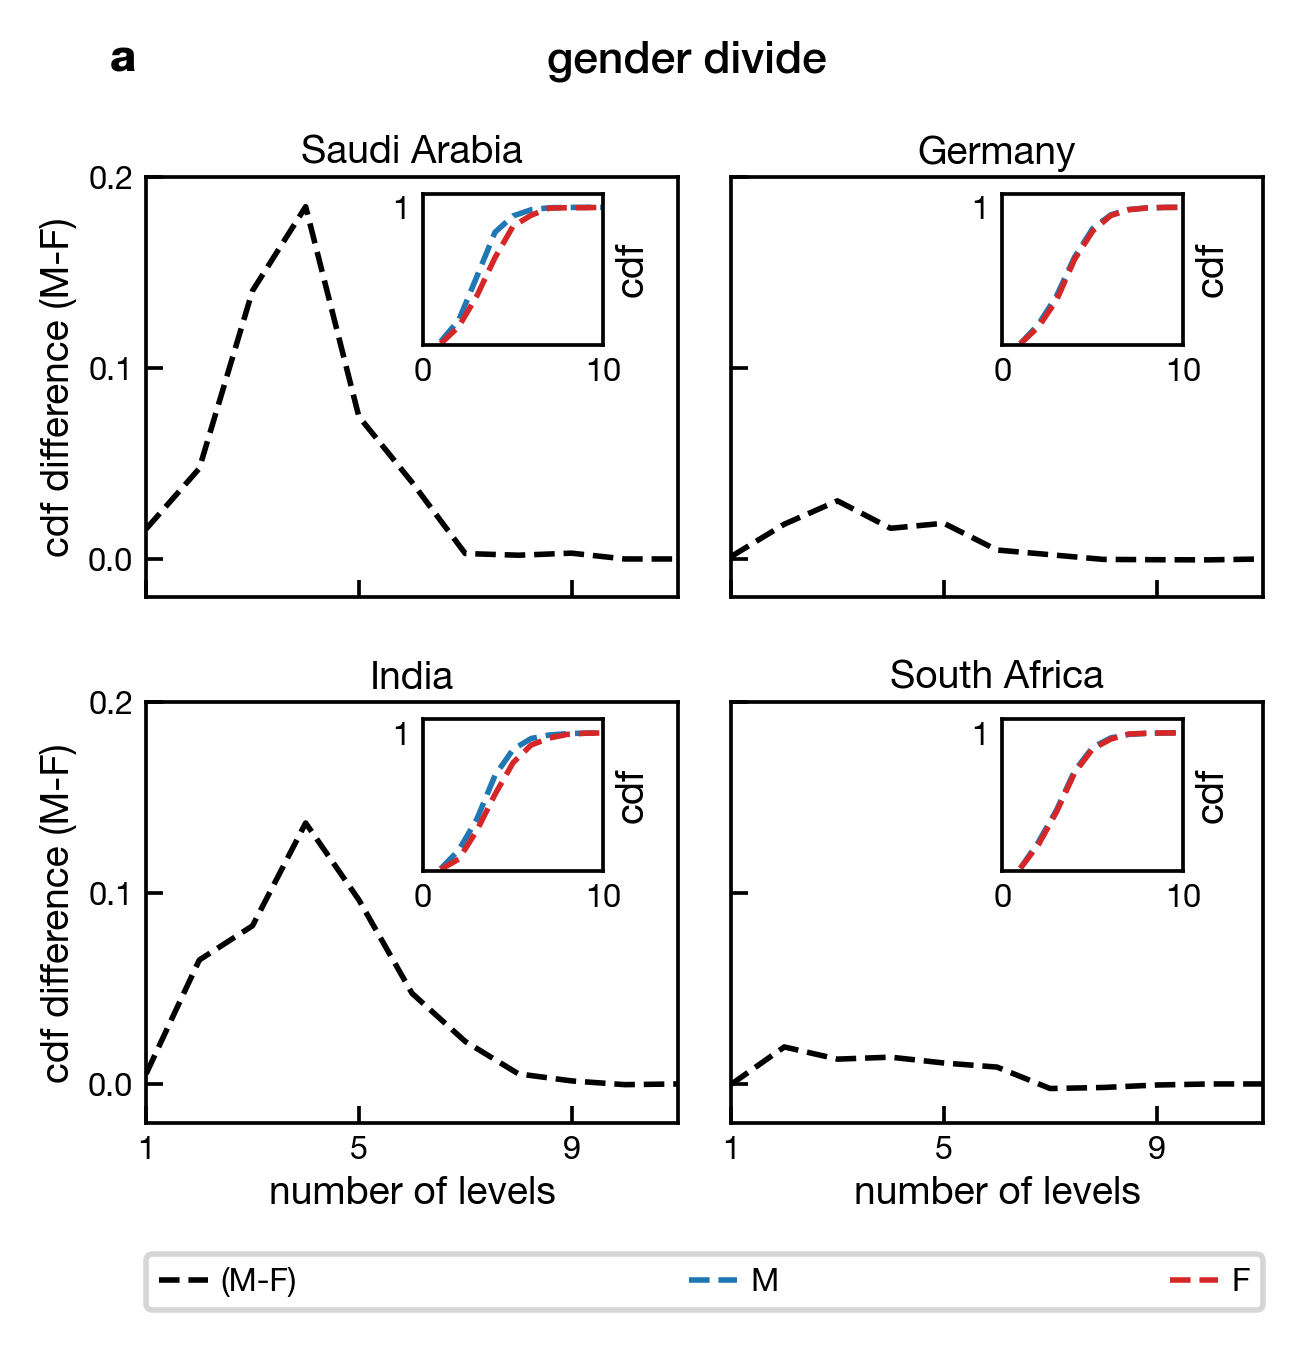

In [84]:
###PLOT FIRST FIGURE

sorted_countries = sorted(by_country.reset_index().values, key = lambda x:x[1][-1], reverse = True)

fig, axes = plt.subplots(2*2, 2, 
                         figsize = (3.60236,3.6),
                         sharex = True, 
                         sharey = 'row', 
                         gridspec_kw={"height_ratios":[0.25,1,0.25, 1]})

#axes[0][0].axis('off')
#axes[0][1].axis('off')


#LARGEST GAP
for ax,r in zip(axes.T[0][0:][::2], sorted_countries[:2]):
    c,(x,x2,y,y2,_,_,_, m) = r
    ax.axis('off')
    ax.text(0.5, 0.4, c, transform=ax.transAxes, horizontalalignment='center',verticalalignment='top',)
    ax.tick_params('both', length=0)

for ax0,r in zip(axes.T[0][1:][::2], sorted_countries[:2]):
    c,(x,x2,y,y2,_,_,_, m)= r
    yy = np.cumsum([j for (i,j) in zip(x2,y2) if i in x]) #FEMALE
    yy2 = np.cumsum([j for (i,j) in zip(x,y) if i in x2]) #MALE
    ax0.plot([i for (i) in x2 if i in x],  yy2-yy , color = 'k', label = 'diff', ls = '--') #MALE - FEMALE
    ax0.set_xlim(1,11)
    ax0.set_ylim(min(yy2-yy)-0.02,max(yy2-yy)+0.01)
    ax0.set_yticks([0,0.1,0.2])
    ax0.set_xticks([1,5,9])

    ax0.set_ylabel('cdf difference (M-F)')
    ax0.yaxis.tick_left()
    ax0.xaxis.tick_bottom()

    
    a = ax0.inset_axes([0.52, 0.6, 0.34, 0.36])
    a.plot(x,np.cumsum(y), color = 'C0', ls = '--')
    a.plot(x2,np.cumsum(y2), color = 'C3', ls = '--')
    a.set_xlim(0,10)
    a.set_xticks([0,10])
    a.set_ylim(0,1.1)
    a.set_yticks([1])
    a.yaxis.set_label_position("right")
    a.set_ylabel('cdf', labelpad=2)
    a.tick_params('both', length=0)
    
ax0.set_xlabel('number of levels')

#SMALLEST GAP

for ax,r in zip(axes.T[1][0:][::2], sorted_countries[-2:][::-1]):
    c,(x,x2,y,y2,_,_,_, m) = r
    ax.axis('off')
    print(c)
    ax.text(0.5, 0.4, c, transform=ax.transAxes,horizontalalignment='center',verticalalignment='top',)
    ax.tick_params('both', length=0)

for ax,r in zip(axes.T[1][1:][::2], sorted_countries[-2:][::-1]):
    c,(x,x2,y,y2,_,_,_, m ) = r
    yy = np.cumsum(y2)
    yy2 = np.cumsum(y)
    ax.plot(x2,  yy2-yy , color = 'k', label = '(M-F)', ls = '--')
    ax.set_xlim(1,11)
    ax.set_yticks([0,0.1,0.2])
    ax.yaxis.tick_left()
    ax.set_xticks([1,5,9])
    ax.xaxis.tick_bottom()

    #ax.tick_params('both', length=0)
    a = ax.inset_axes([0.51, 0.6, 0.34, 0.36])
    a.plot(x,np.cumsum(y), color = 'C0', ls = '--', label = 'M')
    a.plot(x2,np.cumsum(y2), color = 'C3', ls = '--', label = 'F')
    a.set_xlim(0,10)
    a.set_xticks([0,10])
    a.set_ylim(0,1.1)
    a.set_yticks([1])
    a.yaxis.set_label_position("right")
    a.set_ylabel('cdf', labelpad=2)
    a.tick_params('both', length=0)
    

ax.set_xlabel('number of levels')


#LEGEND

x1 =  ax0.get_position().get_points()[0][0]
x2 =  ax.get_position().get_points()[1][0]
handles, labels = axes.T[1][1:][::2][0].get_legend_handles_labels()
handles2, labels2 = a.get_legend_handles_labels()



lgd = plt.figlegend(list(handles)+list(handles2),
                    list(labels)+list(labels2), 
                    ncol = 3,
                    handlelength=1.5,
                    handletextpad=0.4,
                    bbox_transform = fig.transFigure,
                    loc = 'lower center',
                    mode = 'expand',
                    bbox_to_anchor=(x1,0.05,x2-x1,0.1),
                    borderaxespad=0)

plt.subplots_adjust( wspace=0.1, hspace=0, bottom = 0.18, top = 0.91)
plt.text(0.5, 0.91, 'gender divide', horizontalalignment = 'center', transform=fig.transFigure, fontsize = 8, fontdict={ 'family':'Helvetica 65 Medium'})
plt.text(0.1, 0.91, 'a', transform=fig.transFigure, fontsize = 8, weight="bold", fontdict={ 'family':'Helvetica 65 Medium'} )

plt.savefig("../outputs/Figure3/panel_a.svg",dpi=600)


## Panel 2

In [85]:
##MERGE THE TWO DATASETS

kl_divergence = by_country.apply(lambda x:x[-1]).reset_index(name = 'value')


gii_vs_kl = pd.merge(gii_df,kl_divergence, left_on =  'Country', right_on='NAME_0').sort_values(by = 'value',ascending=False)
gii_vs_kl = gii_vs_kl[gii_vs_kl['2017']!='..']
gii_vs_kl['2017'] = gii_vs_kl['2017'].astype(float)
gii_vs_kl = gii_vs_kl[gii_vs_kl.value>0].copy()


In [86]:
##FIT A POWER LAW
logx = (np.log10(gii_vs_kl['2017'].values))
logy = (np.log10(gii_vs_kl['value'].values))

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0]
out = scipy.optimize.leastsq(errfunc, pinit, args=(logx, logy), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = 10.0**pfinal[0]


powerlaw = lambda x, amp, index: amp * (x**index)



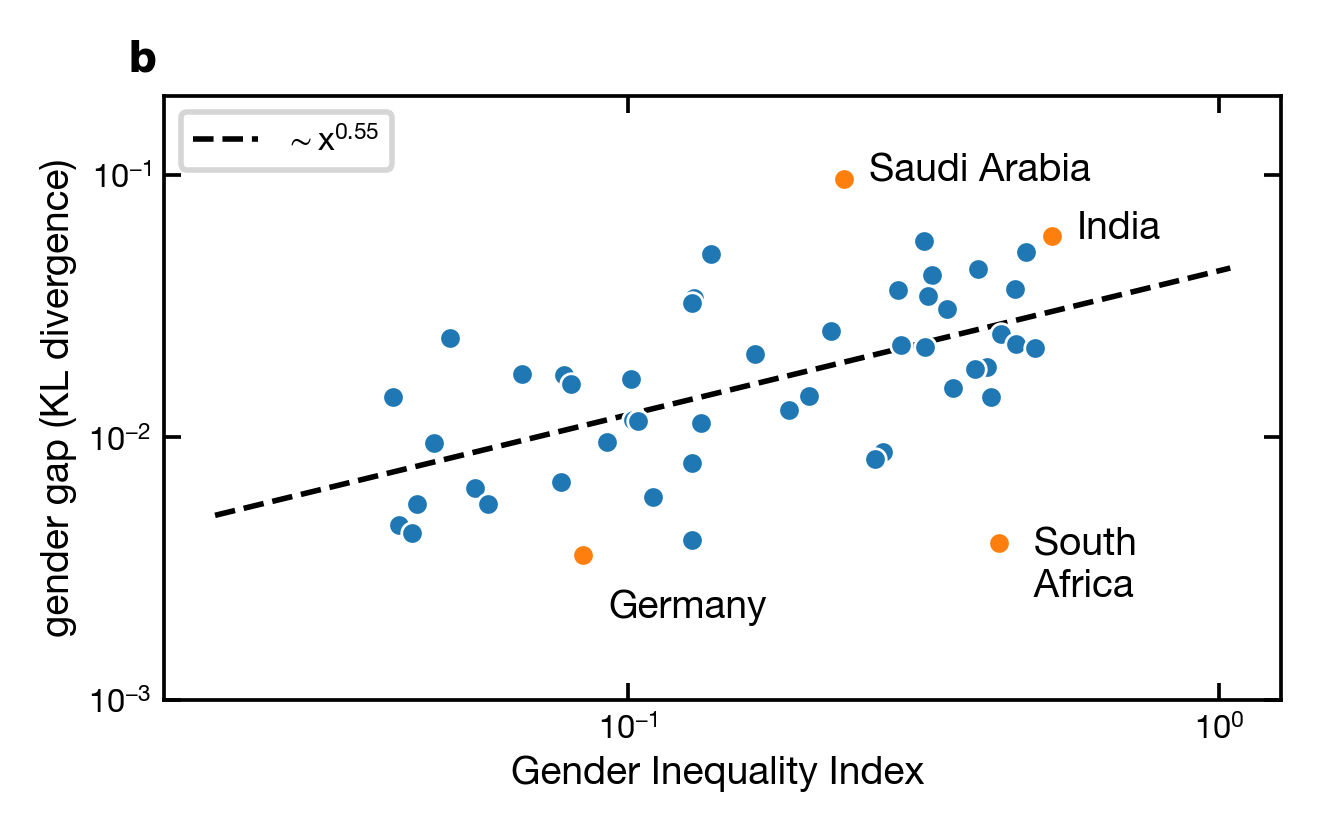

In [87]:


fig, ax = plt.subplots(figsize = (3.60236,2))

##PLOT LINE
x_data = np.linspace(min(gii_vs_kl['2017'].values)/2,max(gii_vs_kl['2017'].values)*2)
ax.plot(x_data,powerlaw(x_data, amp, index), ls = '--', color = 'k', label = r'$\sim x^{%.2f}$'%round(index,2))



###SCATTER POINT
#blue points
ax.scatter(gii_vs_kl['2017'].values[2:-2],gii_vs_kl['value'].values[2:-2], s = 15, alpha = 1, linewidth=0.5, edgecolors='white',zorder=10)
#orange points
ax.scatter(gii_vs_kl['2017'].values[[0,1,-2,-1]],gii_vs_kl['value'].values[[0,1,-2,-1]], linewidth=0.5, color = 'C1', s = 15, alpha = 1, edgecolors='white',zorder=10)

for x,y,s in gii_vs_kl[['2017','value','NAME_0']].values[[0,1,-2,-1]]:
    if s=='South Africa':
        s = ' South\n Africa'
    ax.text(x*1.1,y-0.0015,s)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Gender Inequality Index ')
ax.set_ylabel('gender gap (KL divergence)')
ax.legend(loc = 'upper left')
ax.set_ylim(0.001,0.2)
ax.tick_params('both', which = 'minor', length=0)

plt.text(0.1, 0.91, 'b', transform=fig.transFigure, fontsize = 8, weight="bold", fontdict={ 'family':'Helvetica 65 Medium'} )

plt.savefig("../outputs/Figure3/panel_b.svg",dpi=600)


In [90]:
gii_vs_kl.rename(columns = {"2017":'GII',"value":"KL"})[['Country','GII','KL']].to_csv("../outputs/Figure3/source_data_panel_b.csv",index=False)

In [91]:
##PRINT SPEARMAN CORRELATION
scipy.stats.spearmanr(gii_vs_kl['2017'],gii_vs_kl['value'])

SpearmanrResult(correlation=0.5634634804840483, pvalue=2.040505662067935e-05)

## SI TABLE 1

In [95]:
# SI TABLE
def p_val(x):
    if x>0.05:
        return "ns"
    elif x>0.01:
        return "*"
    elif x>0.001:
        return "**"
    elif x>0.0001:
        return "***"
    else:
        return "****"

    
#PUT RESULTS IN A TABLE
cols =  ['country','KL divergence','Kolmogorov–Smirnov test','Mann–Whitney U test (M>F)','Mann–Whitney U test (F>M)']
cols2 =  ['country','KL divergence','p-value','p-value','p-value']
columns = pd.MultiIndex.from_arrays((cols, cols2))
SI_table = pd.DataFrame([(i[0],round(i[1][7],4), 
                          p_val(i[1][4][1]),
                          p_val(i[1][5][1]),
                          p_val(i[1][6][1])) 
                         for i in sorted_countries], columns = columns)
SI_table.index = SI_table.index+1
SI_table.to_latex("../outputs/Supplementary_Tables/Supplementary_Table1.tex",index = True)

In [96]:
print(SI_table.to_latex(index=True))

\begin{tabular}{llrlll}
\toprule
{} &               country & KL divergence & Kolmogorov–Smirnov test & Mann–Whitney U test (M>F) & Mann–Whitney U test (F>M) \\
{} &               country & KL divergence &                 p-value &                   p-value &                   p-value \\
\midrule
1  &          Saudi Arabia &        0.0962 &                    **** &                        ns &                      **** \\
2  &                 India &        0.0583 &                    **** &                        ns &                      **** \\
3  &               Romania &        0.0559 &                    **** &                        ns &                      **** \\
4  &                Jordan &        0.0509 &                       * &                        ns &                        ** \\
5  &  United Arab Emirates &        0.0498 &                      ns &                        ns &                         * \\
6  &               Ecuador &        0.0437 &                  

In [97]:
import docx 
from docx.shared import Pt
doc = docx.Document()
t = doc.add_table(SI_table.shape[0]+1,SI_table.shape[1])
for j in range(SI_table.shape[-1]):
    t.cell(0,j).text = SI_table.columns[j]

for i in range(SI_table.shape[0]):
    for j in range(SI_table.shape[-1]):
        t.cell(i+1,j).text = str(SI_table.values[i,j])
for row in t.rows:
    for cell in row.cells:
        paragraphs = cell.paragraphs
        for paragraph in paragraphs:
            for run in paragraph.runs:
                font = run.font 
                font.name = 'Helvetica 55 Roman'
                font.size = Pt(7)
doc.save("../outputs/Extended_data/Extended_data_5.docx")

In [98]:
SI_table.to_excel("../outputs/Supplementary_Tables/Supplementary_Table1.xlsx")

## NOW DO THE SAME FOR THE CONTAINERS SIZES

In [99]:
BINS = np.linspace(1,7,30)
#COMPUTE STATS BY COUNTRY

df_merged_filtered['size2_level'] = df_merged_filtered['sizes'].apply(lambda x: (sorted(x)[0]) if len(x)>0 else np.nan)
by_country2 = df_merged_filtered[['gender','size2_level','NAME_0']].groupby('NAME_0')\
                            .apply(lambda x: mf_difference(x[x.gender=='MALE']['size2_level'].dropna(),
                                                           x[x.gender=='FEMALE']['size2_level'].dropna(),
                                                           bins=BINS, 
                                                           log_hist=True))

In [100]:
#COMPUTE STATS BY COUNTRY
sorted_countries2 = sorted(by_country2.reset_index().values, key = lambda x:x[1][-1], reverse = True)


## SI Table 2

In [101]:

cols =  ['country','KL divergence','Kolmogorov–Smirnov test','Mann–Whitney U test (M>F)','Mann–Whitney U test (F>M)']
cols2 =  ['country','KL divergence','p-value','p-value','p-value']
columns = pd.MultiIndex.from_arrays((cols, cols2))
SI_table = pd.DataFrame([(i[0],round(i[1][7],4), 
                          p_val(i[1][4][1]),
                          p_val(i[1][5][1]),
                          p_val(i[1][6][1])) 
                         for i in sorted_countries2], columns = columns)
SI_table.index = SI_table.index+1
SI_table.to_latex("../outputs/Supplementary_Tables/Supplementary_Table2.tex",index = True)

In [102]:
print(SI_table.to_latex(index=True))

\begin{tabular}{llrlll}
\toprule
{} &               country & KL divergence & Kolmogorov–Smirnov test & Mann–Whitney U test (M>F) & Mann–Whitney U test (F>M) \\
{} &               country & KL divergence &                 p-value &                   p-value &                   p-value \\
\midrule
1  &          Saudi Arabia &        0.2121 &                    **** &                      **** &                        ns \\
2  &                Jordan &        0.2006 &                    **** &                      **** &                        ns \\
3  &             Singapore &        0.1326 &                    **** &                      **** &                        ns \\
4  &               Romania &        0.0946 &                    **** &                      **** &                        ns \\
5  &             Indonesia &        0.0926 &                    **** &                       *** &                        ns \\
6  &               Estonia &        0.0901 &                  

In [103]:
SI_table.to_excel("../outputs/Supplementary_Tables/Supplementary_Table2.xlsx")

# 3 - Urban rural (number of scales)

In [104]:

    
BINS = np.linspace(1,10,30)

#COMPUTE STATS BY COUNTRY

urb_rur = [mf_difference(
                       df_merged_filtered[df_merged_filtered.urban_rural=='rural']['sizes'].apply(lambda x:np.log10(sorted(x)[i]) if len(x)>i else np.nan).dropna(),
                       df_merged_filtered[df_merged_filtered.urban_rural=='urban']['sizes'].apply(lambda x:np.log10(sorted(x)[i]) if len(x)>i else np.nan).dropna(),
                       bins=BINS, 
                       log_hist=False)for i in range(7)]

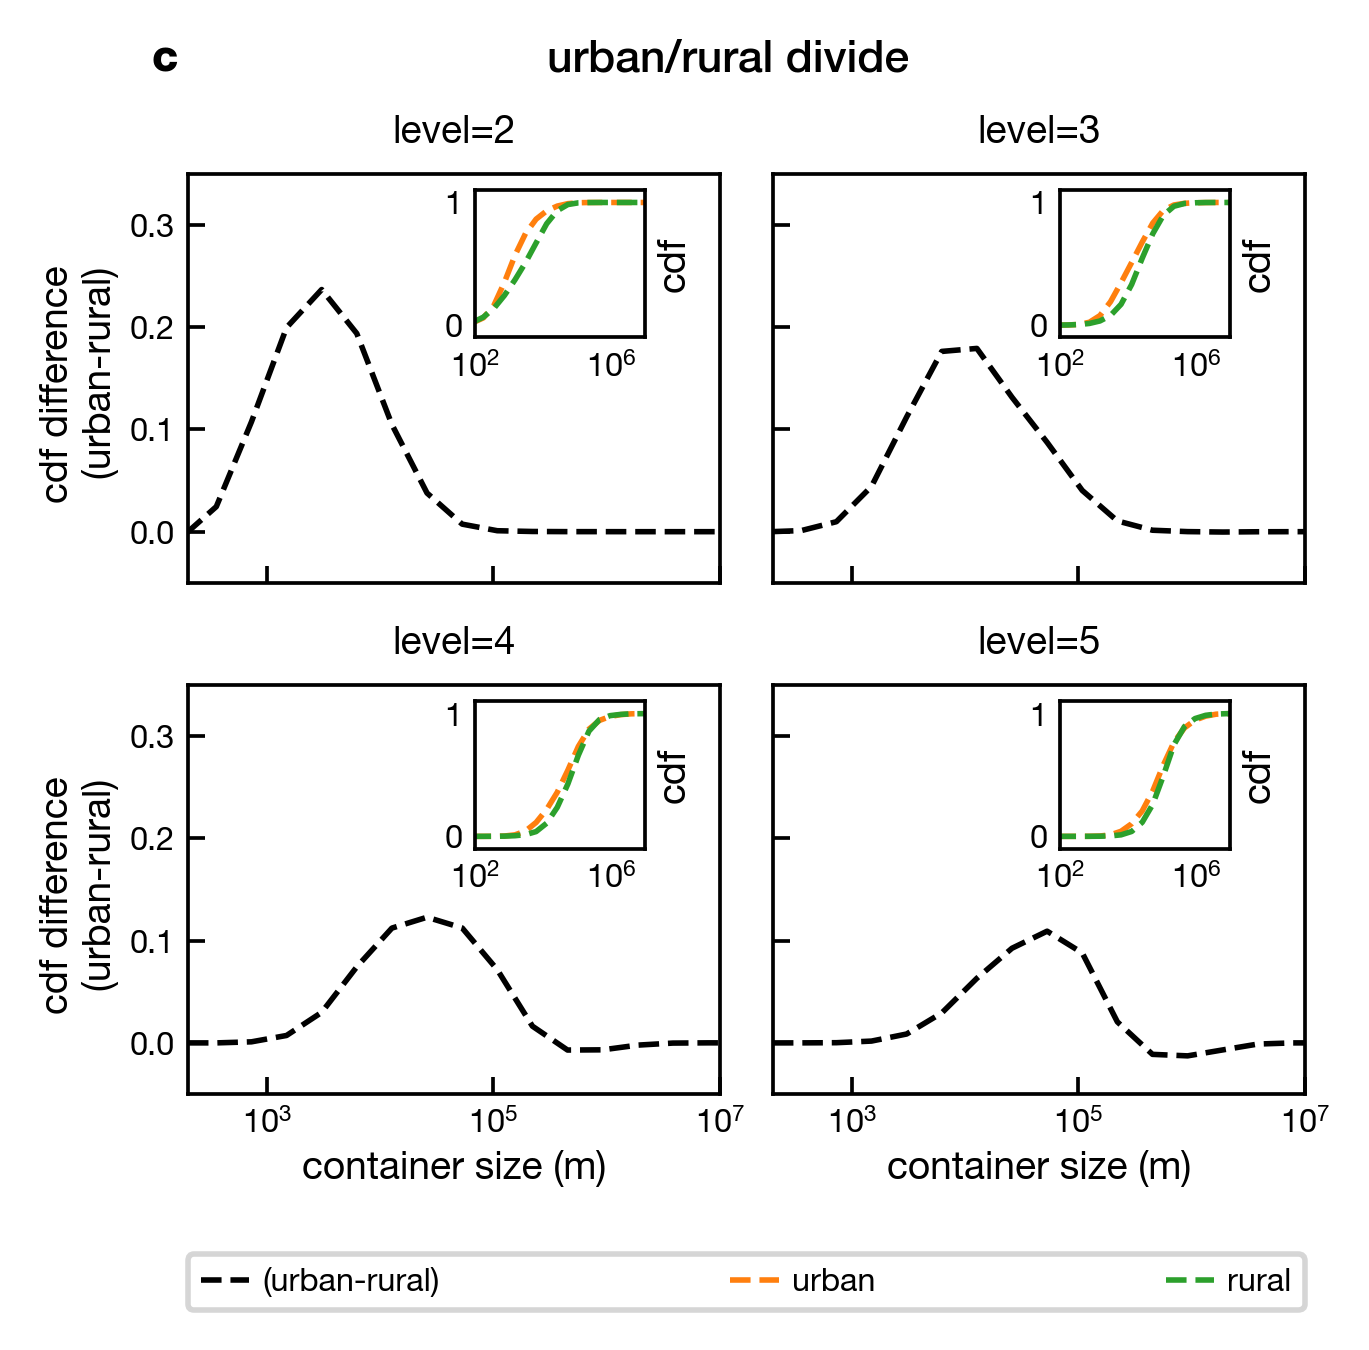

In [105]:

delta = BINS[1] - BINS[0]

#fig, axes = plt.subplots(2*2+1, 2, figsize = (6.69/2,3.6), sharex = True, sharey = 'row', gridspec_kw={"height_ratios":[0.02,0.35,1,0.35, 1]})
fig, axes = plt.subplots(2*2, 2, 
                         figsize = (3.60236,3.6),
                         sharex = True, 
                         sharey = 'row', 
                         gridspec_kw={"height_ratios":[0.25,1,0.25, 1]})

levels = [1,3,2,4]

#LARGEST GAP
n = 0
for ax,r in zip(list(axes.T[0][0:][::2])+list(axes.T[1][0:][::2]),  
                [urb_rur[0],urb_rur[2],urb_rur[1],urb_rur[3]]):
    
    #x_rural,x_urban,y_rural,y_urban,_, _, _, _ = r
    ax.axis('off')
    ax.text(0.5, 0.58, 'level={}'.format(levels[n]+1),transform=ax.transAxes,horizontalalignment='center',verticalalignment='top',)
    ax.tick_params('both', length=0)
    n+=1


for ax,r in zip(list(axes.T[0][1:][::2])+list(axes.T[1][1:][::2]), [urb_rur[0],urb_rur[2],urb_rur[1],urb_rur[3]]):
    x_rural,x_urban,y_rural,y_urban,_, _, _, _ = r
    y_rural_cum = np.cumsum(y_rural)*delta #FEMALE
    y_urban_cum = np.cumsum(y_urban)*delta #MALE
    ax.plot([10**i for (i) in x_urban],  y_urban_cum-y_rural_cum , color = 'k', label = '(urban-rural)', ls = '--')
    ax.set_xlim(2*10**2,10**7)
    ax.set_xticks([10**3,10**5,10**7])

    ax.set_ylim(-0.05,0.35)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    ax.set_xscale('log')

    
    a = ax.inset_axes([0.54, 0.6, 0.32, 0.36])
    a.plot([10**i for (i) in x_urban],y_urban_cum, color = 'C1', ls = '--', label = 'urban')
    a.plot([10**i for (i) in x_rural],y_rural_cum, color = 'C2', ls = '--', label = 'rural')
    a.set_xlim(10**2,10**7)
    a.set_ylim(-0.1,1.1)
    a.set_xscale('log')
    a.yaxis.set_label_position("right")
    a.set_ylabel('cdf', labelpad=2)
    a.tick_params('both', length=0)

axes.T[0][-1].set_xlabel('container size (m)')
axes.T[1][-1].set_xlabel('container size (m)')

axes.T[0][-1].set_ylabel('cdf difference \n (urban-rural)')
axes.T[0][-3].set_ylabel('cdf difference \n (urban-rural)')

#axes.T[1][1].set_ylabel('urban/rural gap')
axes.T[1][1].set_xticks([10**3,10**5,10**7])

##LEGEND
x1 =  axes.T[0][0].get_position().get_points()[0][0]
x2 =  axes.T[1][0].get_position().get_points()[1][0]
handles, labels = axes.T[1][1:][::2][0].get_legend_handles_labels()
handles2, labels2 = a.get_legend_handles_labels()



lgd = plt.figlegend(list(handles)+list(handles2),
                    list(labels)+list(labels2), 
                    ncol = 3,
                    handlelength=1.5,
                    handletextpad=0.4,
                    bbox_transform = fig.transFigure,
                    loc = 'lower center',
                    mode = 'expand',
                    bbox_to_anchor=(x1,0.05,x2-x1,0.1),
                    borderaxespad=0)

plt.subplots_adjust( wspace=0.1, hspace=0, bottom = 0.2, top = 0.91)
plt.text(0.5, 0.91, 'urban/rural divide', horizontalalignment = 'center', transform=fig.transFigure, fontsize = 8, fontdict={ 'family':'Helvetica 65 Medium'} )
plt.text(0.1, 0.91, 'c', transform=fig.transFigure, fontsize = 8, weight="bold", fontdict={ 'family':'Helvetica 65 Medium'} )

#plt.show()
plt.savefig("../outputs/Figure3/panel_c.svg",dpi=600)


In [106]:
# SI TABLE
def p_val(x):
    if x>0.05:
        return "ns"
    elif x>0.01:
        return "*"
    elif x>0.001:
        return "**"
    elif x>0.0001:
        return "***"
    else:
        return "****"

cols =  ['country','KL','KS test','MW test (urban>rural)','Mann–Whitney U test (rural>urban)']
cols2 =  ['country','','p-value','p-value','p-value']
columns = pd.MultiIndex.from_arrays((cols, cols2))
SI_table = pd.DataFrame([(n+2,
                          round(i[7],4), 
                          p_val(i[4][1]),
                          p_val(i[5][1]),
                          p_val(i[6][1])) for n,i in enumerate(urb_rur)], columns = columns)
SI_table.index = SI_table.index+1
SI_table.to_latex("../outputs/Supplementary_Tables/Supplementary_Table3.tex",index = True)

In [107]:
SI_table.to_excel("../outputs/Supplementary_Tables/Supplementary_Table3.xlsx")

# Walkability

In [108]:
df_merged_filtered['scale_size_1'] = df_merged_filtered['sizes'].apply(lambda x: np.log10(x[0]) if len(x)>0 else np.nan)
df_merged_filtered['scale_size_2'] = df_merged_filtered['sizes'].apply(lambda x: np.log10(x[1]) if len(x)>1 else np.nan)
df_merged_filtered['scale_size_3'] = df_merged_filtered['sizes'].apply(lambda x: np.log10(x[2]) if len(x)>2 else np.nan)
df_merged_filtered['scale_size_4'] = df_merged_filtered['sizes'].apply(lambda x: np.log10(x[3]) if len(x)>3 else np.nan)



In [109]:
m = df_merged_filtered.score.dropna().min()
M = df_merged_filtered.score.dropna().max()

def find_percentiles(x, N = 500): 
    a = [np.median(np.random.choice(x.dropna(),len(x.dropna()))) for _ in range(N)]
    return sorted(a)[int(N*5/100.)],sorted(a)[int(N*95/100.)]

df_merged_filtered['score2'] = pd.cut(df_merged_filtered['score'],bins = np.linspace(m,M,18),labels = np.linspace(m,M,18)[:-1])


scores = []
for n in range(1,5):
    r1 = df_merged_filtered.groupby('score2')['scale_size_{}'.format(n)].agg(['median','size',find_percentiles])
    r1 = r1[r1['size']>100]
    scores.append(r1)

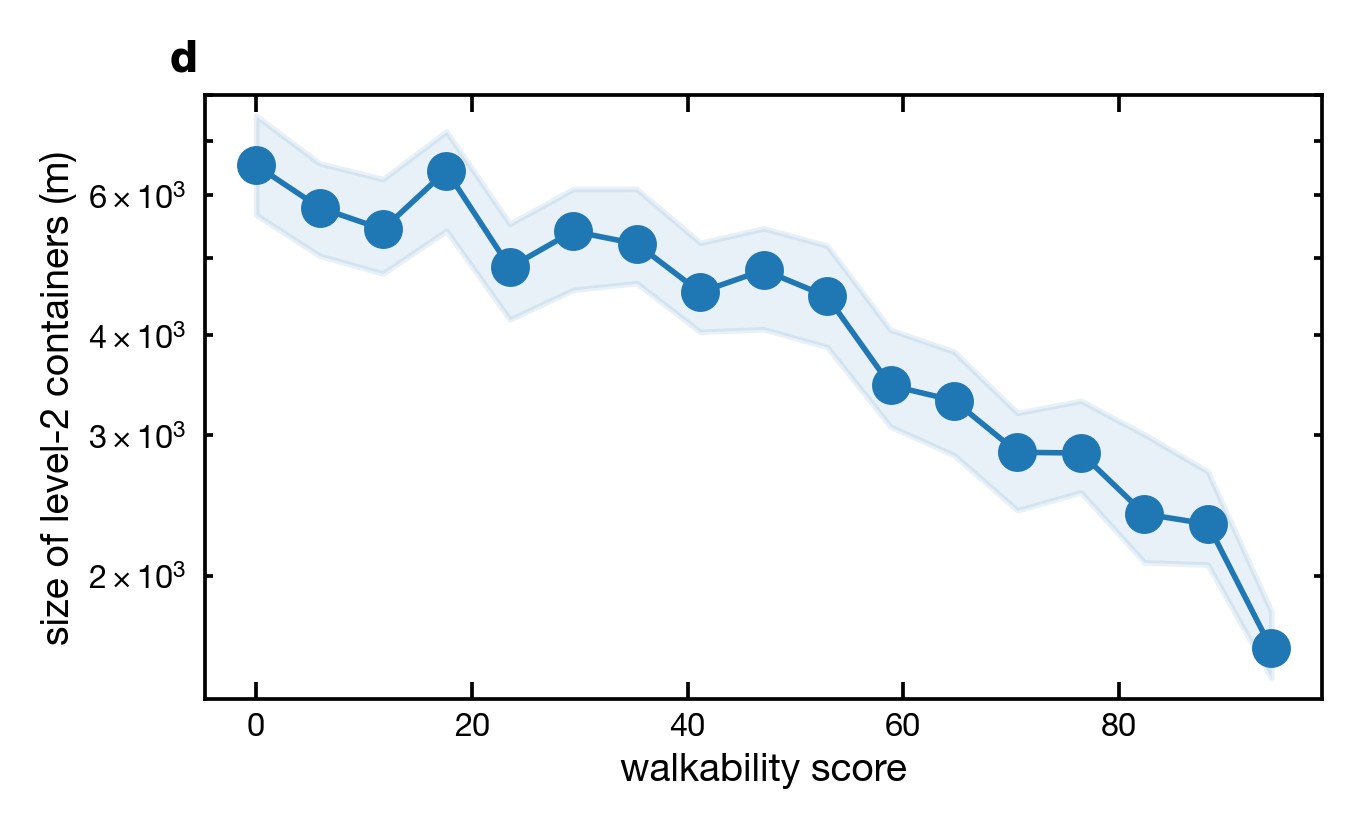

In [110]:
n = 0
r1 = scores[n]

fig, ax = plt.subplots(figsize = (3.60236,2))

ax.plot(list(r1.index.values), [10**i for i in r1['median']], marker = 'o', color = 'C{}'.format(n), label = 'level 2 containers')
ax.fill_between(list(r1.index.values), [10**i for i in r1['find_percentiles'].apply(lambda x:x[0])],[10**i for i in r1['find_percentiles'].apply(lambda x:x[1])],alpha = 0.1, label = 'IQR by bootstrap', color = 'C{}'.format(n))
ax.set_xlabel('walkability score')
ax.set_ylabel('size of level-2 containers (m)'.format(n+2))
ax.set_yscale('log')
#ax.legend()
ax.set_ylim(1400,8000)

plt.text(0.1, 0.91, 'd', transform=fig.transFigure, fontsize = 8, weight="bold", fontdict={ 'family':'Helvetica 65 Medium'} )

plt.savefig("../outputs/Figure3/panel_d.svg",dpi=600)

In [120]:
r1['perc_25'] = r1['find_percentiles'].apply(lambda x:10**x[0])
r1['perc_75'] = r1['find_percentiles'].apply(lambda x:10**x[1])
r1['median_size'] = r1['median'].apply(lambda x:10**x)
r1.reset_index().rename(columns = {'score2':'walkability_score'})[['walkability_score','median_size','perc_25','perc_75']].to_csv("../outputs/Figure3/source_data_panel_d.csv",index = False)

In [27]:
print(scipy.stats.spearmanr(list(scores[0].index.values), [10**i for i in scores[0]['median']]))

SpearmanrResult(correlation=-0.982843137254902, pvalue=2.000914024116428e-12)


SpearmanrResult(correlation=-0.6887254901960785, pvalue=0.0022327017176758217)
SpearmanrResult(correlation=0.02450980392156863, pvalue=0.9256077760199253)
SpearmanrResult(correlation=0.07107843137254903, pvalue=0.7863266619781206)


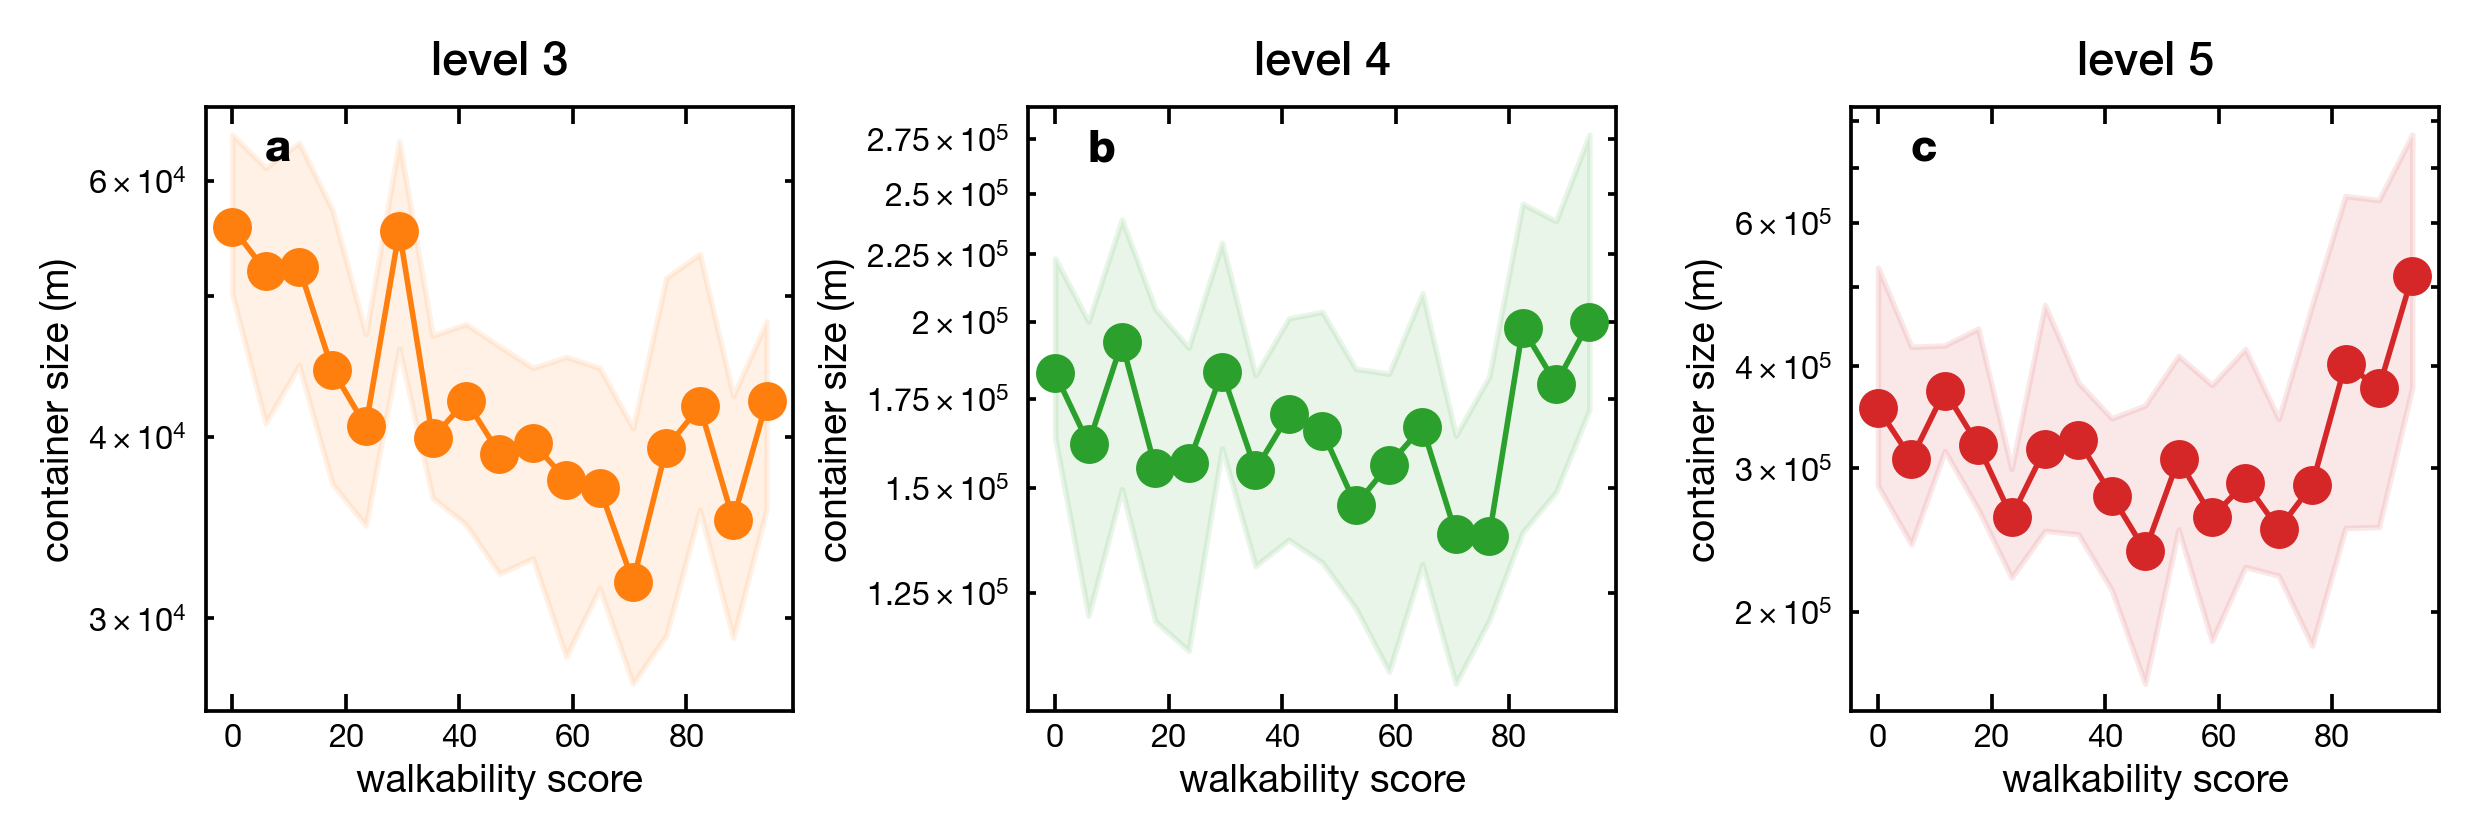

In [28]:
n=1
fig, axes = plt.subplots(1,3, figsize = (3.60236*2,2))
letters = ['d','a','b','c']
plt.subplots_adjust(wspace=0.4)

for ax,r in zip(axes,scores[1:]):
    plt.text(0.1, 0.91, letters[n], transform=ax.transAxes, fontsize = 8, weight="bold", fontdict={ 'family':'Helvetica 65 Medium'} )

    ax.plot(list(r.index.values), [10**i for i in r['median']], marker = 'o', color = 'C{}'.format(n))
    ax.fill_between(list(r.index.values), [10**i for i in r['find_percentiles'].apply(lambda x:x[0])],
                    [10**i for i in r['find_percentiles'].apply(lambda x:x[1])],alpha = 0.1, color = 'C{}'.format(n))
    ax.set_title("level {}".format(n+2),fontdict={ 'family':'Helvetica 65 Medium'})
    ax.set_xlabel('walkability score')
    ax.set_ylabel('container size (m)')
    ax.set_yscale('log')
    n+=1
    print(scipy.stats.spearmanr(list(r.index.values), [10**i for i in r['median']]))

